In [1]:
import uproot
import awkward as ak
import hist
import coffea
from coffea.nanoevents import NanoAODSchema, NanoEventsFactory
import mplhep as hep

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors

import glob
import sys
import os

In [2]:
# configure plot style
hep.style.use("CMS")

In [3]:
class JMENanoAODSchema(NanoAODSchema):
    """JMENano schema builder

    JMENano is an extended NanoAOD format that includes various jet collections down to low pt for JME studies
    More info at https://twiki.cern.ch/twiki/bin/viewauth/CMS/JMECustomNanoAOD
    Customization at https://github.com/nurfikri89/cmssw/blob/master/PhysicsTools/NanoAOD/python/custom_jme_cff.py
    """

    mixins = {
        **NanoAODSchema.mixins,
        "JetCalo": "Jet",
        #"JetPuppi": "Jet",
        "JetCHS": "Jet",
        "FatJetForJEC": "FatJet",
        "FatJetCHS": "FatJet",
    }
    all_cross_references = {
        **NanoAODSchema.all_cross_references,
        "FatJetForJEC_genJetIdx": "GenJetAK8ForJEC",
        "FatJetCHS_genJetIdx": "GenJetAK8ForJEC",
        "JetCalo_genJetIdx": "GenJet",
#        "JetPuppi_genJetIdx": "GenJet",
        "JetCHS_genJetIdx": "GenJet",
    }

class ScoutingJMENanoAODSchema(JMENanoAODSchema):
    
    mixins = {
        **JMENanoAODSchema.mixins,
#         "JetCalo": "Jet",
#         #"JetPuppi": "Jet",
#         "JetCHS": "Jet",
#         "FatJetForJEC": "FatJet",
#         "FatJetCHS": "FatJet",
        # Scouting
        "ScoutingJet": "Jet",
        "ScoutingFatJet": "FatJet",
        "ScoutingRho": "Rho"
    }
    all_cross_references = {
        **JMENanoAODSchema.all_cross_references,
#        "FatJetForJEC_genJetIdx": "GenJetAK8ForJEC",
#        "FatJetCHS_genJetIdx": "GenJetAK8ForJEC",
#        "JetCalo_genJetIdx": "GenJet",
#        "JetPuppi_genJetIdx": "GenJet",
        "JetCHS_genJetIdx": "GenJet",
        # Scouting
        "ScoutingJet_genJetIdx": "GenJet",
        "ScoutingFatJet_genJetAK8Idx": "GenJetAK8ForJEC",
    }

In [4]:
input_dir = "/eos/user/a/adlintul/QCD_Pt-15To7000_TuneCP5_13p6TeV_pythia8/Run3Summer22/230130_122950"
filelist = glob.glob(os.path.join(input_dir, "*/nanoaod_*.root"))

In [52]:
fname = filelist[0]
events = NanoEventsFactory.from_root(
            fname, 
            schemaclass=ScoutingJMENanoAODSchema,
            metadata={"dataset": "test"}
            ).events()

In [53]:
sorted(events.fields)

['BeamSpot',
 'CaloMET',
 'ChsMET',
 'CorrT1METJet',
 'DST',
 'DeepMETResolutionTune',
 'DeepMETResponseTune',
 'Electron',
 'FatJet',
 'FatJetCHS',
 'FatJetForJEC',
 'Flag',
 'FsrPhoton',
 'GenDressedLepton',
 'GenIsolatedPhoton',
 'GenJet',
 'GenJetAK8',
 'GenJetAK8ForJEC',
 'GenMET',
 'GenPart',
 'GenProton',
 'GenVisTau',
 'GenVtx',
 'Generator',
 'HLT',
 'HLTriggerFinalPath',
 'HLTriggerFirstPath',
 'HTXS',
 'IsoTrack',
 'Jet',
 'JetCHS',
 'JetCalo',
 'L1',
 'L1PreFiringWeight',
 'L1Reco',
 'L1simulation',
 'LowPtElectron',
 'MC',
 'MET',
 'Muon',
 'OtherPV',
 'PSWeight',
 'PV',
 'Photon',
 'Pileup',
 'PuppiMET',
 'RawMET',
 'RawPuppiMET',
 'Rho',
 'SV',
 'ScoutingDisplacedVertex',
 'ScoutingElectron',
 'ScoutingFatJet',
 'ScoutingJet',
 'ScoutingMET',
 'ScoutingMuon',
 'ScoutingPhoton',
 'ScoutingPrimaryVertex',
 'ScoutingRho',
 'ScoutingTrack',
 'SoftActivityJet',
 'SoftActivityJetHT',
 'SoftActivityJetHT10',
 'SoftActivityJetHT2',
 'SoftActivityJetHT5',
 'SoftActivityJetNjets10

In [54]:
# create HLT AK4 and AK8 jets
events["TrigObjJMEAK4"] = events.TrigObj[events.TrigObj.id == 1]
events.TrigObjJMEAK8 = events.TrigObj[events.TrigObj.id == 6]

In [55]:
h_off_scouting = hist.new.Regular(100, 1, 10000, name="off", label="PUPPI Jet", transform=hist.axis.transform.log)\
                        .Regular(100, 1, 10000, name="scouting", label="Scouting Jet", transform=hist.axis.transform.log)\
                        .Int64()

In [56]:
events = events[ak.num(events.ScoutingJet) > 0] # at least one scouting jet

threshold = 0.2
matched_jets = ak.cartesian([events.Jet, events.ScoutingJet])
delta_R_one = matched_jets.slot0.delta_r(matched_jets.slot1) # compute delta r
matched_mask = (delta_R_one < threshold)
matched_jets = matched_jets[matched_mask] # apply mask
matched_jets = matched_jets[ak.num(matched_jets) > 0] # select non-empty entries
matched_off_jets = matched_jets.slot0
matched_on_jets = matched_jets.slot1

h_off_scouting.fill(off=ak.flatten(matched_off_jets.pt), scouting=ak.flatten(matched_on_jets.pt));

No handles with labels found to put in legend.


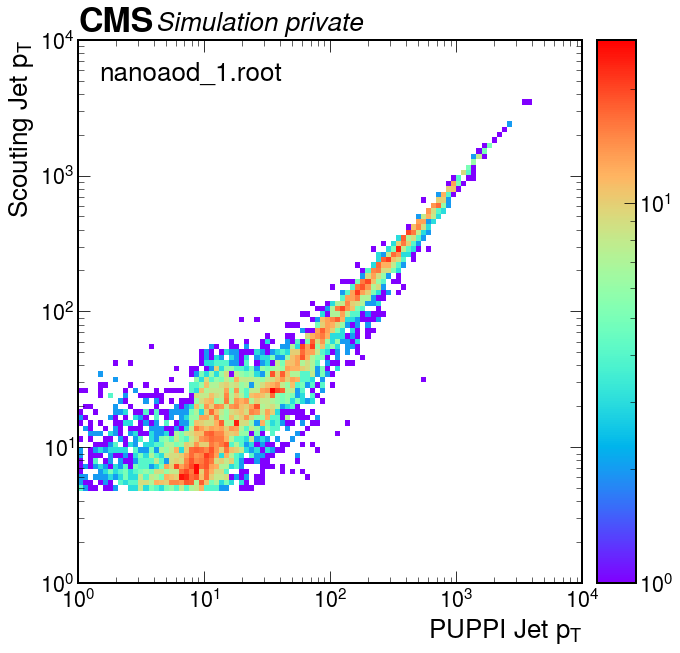

In [61]:
fig, ax = plt.subplots()
h_off_scouting.plot2d(ax=ax, cmap=cm.rainbow, alpha=1, norm=colors.LogNorm())
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("{} ".format(h_off_scouting.axes["off"].label) + r"$p_{T}$")
ax.set_ylabel("{} ".format(h_off_scouting.axes["scouting"].label) + r"$p_{T}$")
hep.cms.text("Simulation private")
ax.legend(title="nanoaod_1.root", loc="upper left")
#plt.savefig("PUPPI_HLT_data.png", bbox_inches="tight", dpi=100)
plt.show()

In [62]:
import itertools
jet_names = ["Jet", "TrigObjJMEAK4", "ScoutingJet"]
jet_labels = ["AK4PUPPI", "AK4HLT", "AK4Scouting"]
itertools.combinations(zip(jet_names, jet_labels), 2)

In [59]:
def plot_correlation(events):
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    for idx, pair in enumerate(itertools.combinations(zip(jet_names, jet_labels), 2)):
        ax = axs[idx]
        (first_jet_name, first_jet_label), (second_jet_name, second_jet_label) = pair
        
        h = hist.new.Regular(100, 1, 10000, name="first", label=first_jet_label, transform=hist.axis.transform.log)\
                    .Regular(100, 1, 10000, name="second", label=second_jet_label, transform=hist.axis.transform.log)\
                    .Int64()
        
        events = events[ak.num(events[first_jet_name]) > 0]
        events = events[ak.num(events[second_jet_name]) > 0]

        threshold = 0.2
        matched_jets = ak.cartesian([events[first_jet_name], events[second_jet_name]])
        delta_R_one = matched_jets.slot0.delta_r(matched_jets.slot1) # compute delta r
        matched_mask = (delta_R_one < threshold)
        matched_jets = matched_jets[matched_mask] # apply mask
        matched_jets = matched_jets[ak.num(matched_jets) > 0] # select non-empty entries
        matched_off_jets = matched_jets.slot0
        matched_on_jets = matched_jets.slot1

        h.fill(first=ak.flatten(matched_off_jets.pt), second=ak.flatten(matched_on_jets.pt))
        
        h.plot2d(ax=ax, cmap=cm.rainbow, alpha=1, norm=colors.LogNorm())
        ax.set_yscale("log")
        ax.set_xscale("log")
        ax.set_xlabel("{} ".format(h.axes["first"].label) + r"$p_{T}$")
        ax.set_ylabel("{} ".format(h.axes["second"].label) + r"$p_{T}$")
        hep.cms.text("Simulation private")
        ax.legend(title="nanoaod_1.root", loc="upper left")

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


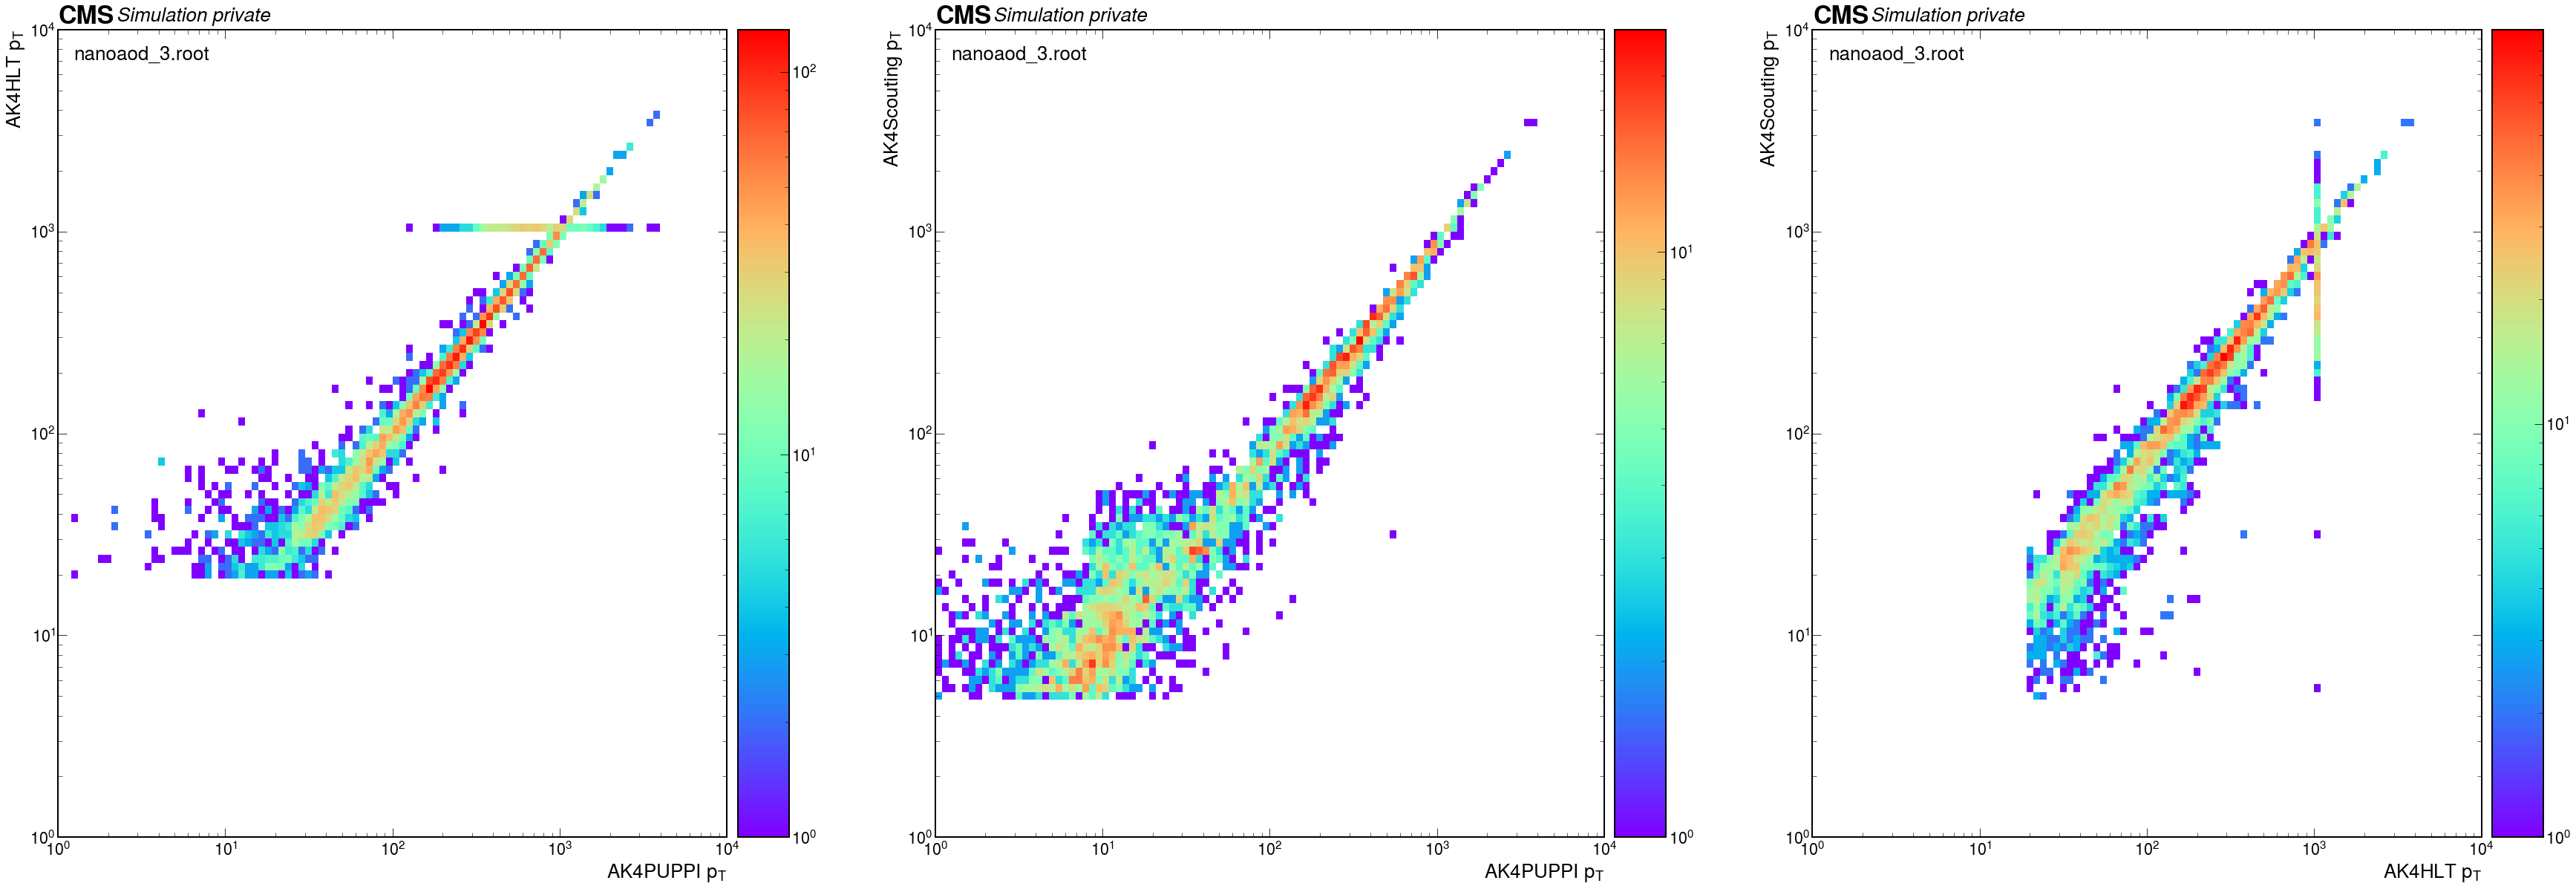

In [60]:
plot_correlation(events)